In [1]:
import pyximport
pyximport.install()
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)
import numpy as np
import astropy.units as u
import gammapy
import operator
from gammapy.maps import Map
from gammapy.modeling import Fit,  Parameters, Covariance , Parameter
from gammapy.datasets import MapDataset ,Datasets
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SkyModel,
    PointSpatialModel,
    GaussianSpatialModel,
    Models,
    FoVBackgroundModel,
    GaussianSpectralModel,
    CompoundSpectralModel
)
import sys
sys.path.append('/home/katrin/Documents/nuisance_summary/')
sys.path.append('../..')
from Dataset_Creation import sys_dataset
import Dataset_load 

In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
figformat = 'png'

loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-plg.fits.gz


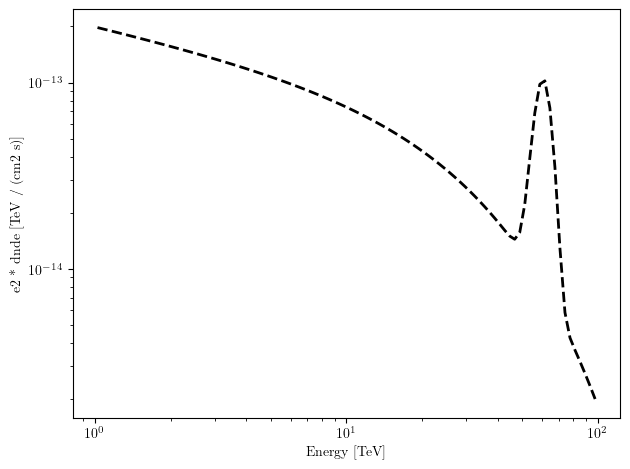

In [4]:
scale = 0.05
sigma = 4.5
mean = 60
amplitude_ = 3e-16

parameters = [
            Parameter("sigma", value =sigma),
            Parameter("mean", value = mean),
             Parameter("amplitude", value = 4.11e-12 * scale),
             Parameter("amplitude_", value = amplitude_),
    
             ]

dataset_asimov = Dataset_load.create_asimov('plg', source = "PKSflare",
                                            parameters= Parameters(parameters))

# set npred again
dataset_asimov.counts = dataset_asimov.npred()

energy_bounds = [1 ,100 ]* u.TeV
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2,  
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
plt.tight_layout()
fig = plt.gcf()
fig.savefig(f'plots/2_spectrum_input_simga_{sigma}.{figformat}')



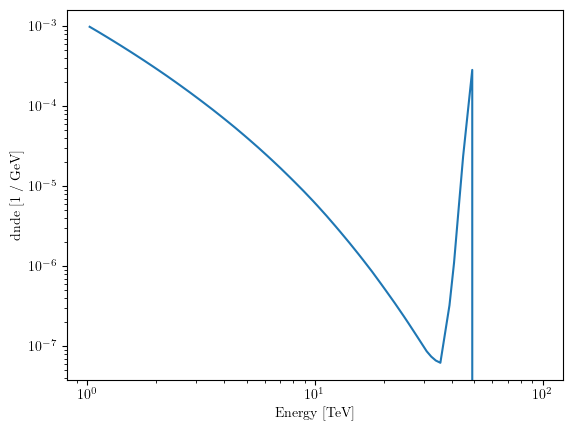

In [5]:
import numpy as np
import astropy.units as u
# %matplotlib inline
from matplotlib.colors import LogNorm
from gammapy.astro.darkmatter import (
    DarkMatterAnnihilationSpectralModel,
    JFactory,
    PrimaryFlux,
    profiles,
)
fig, ax = plt.subplots()
fluxes = PrimaryFlux(mDM="10 TeV", channel="gamma")
fluxes.mDM = 70*u.TeV
ax.set_yscale("log")
ax.set_ylabel("dN/dE")
channel = 'gamma'
fluxes.table_model.plot(
            energy_bounds=[1 ,100 ]* u.TeV,
            ax=ax,
            label=channel,
            yunits=u.Unit("1/GeV"),
        )



plt.subplots_adjust(hspace=0.9)

In [6]:
zero = 1e-12

sigmass = [0.0]
simgass_assumed = [0.1]
res_assumed = 0.1
biass = [0.0]

In [7]:
def create_dataset(b, s):
    i = 0
    sys_d_cor = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0,
                        tilt = 0,
                        bias = b, 
                        resolution = s,
                        rnd = False,
                        e_reco_creation=10,
                        gun = True,
                        cutoff = True)
    dataset_conv = sys_d_cor.create_dataset()
    dataset_conv_N = sys_d_cor.create_dataset_N(10)
    dataset_conv_N.models.parameters['bias'].frozen  = True
    dataset_conv_N.models.parameters['norm_nuisance'].frozen  = True
    
    dataset_conv_N.e_reco_n = 10

    penalising_invcovmatrix = np.zeros((4,4))
    
    np.fill_diagonal(penalising_invcovmatrix, [1/zero**2, 1/simgass_assumed[i]**2, 1/zero**2, 1/zero**2])
    dataset_conv_N.penalising_invcovmatrix = penalising_invcovmatrix
    #dataset_conv_N.irf_model.eff_area_model = None
    #dataset_conv_N.irf_model.eff_area_model = None
    i +=1
    return dataset_conv, dataset_conv_N

datasets_conv =[]
datasets_conv_N =[]

for r in sigmass:
    dataset_conv, dataset_conv_N  = create_dataset(biass[0], r)
    datasets_conv.append(dataset_conv)
    datasets_conv_N.append(dataset_conv_N)
    
dataset_conv_extreme, dataset_conv_N_extreme  = create_dataset(biass[0], 0.1)


In [8]:
prior_notset = dataset_conv_N_extreme.penalising_invcovmatrix.diagonal() == 1/zero**2
for i, p in enumerate(prior_notset):
    dataset_conv_N_extreme.models[-1].parameters[i].frozen = p
    print(p)

True
False
True
True


In [9]:
 print(dataset_conv_N_extreme.models[-1])

IRFModels

  Name                      : dataset N-irf
  Datasets names            : dataset N
  EReco  model type         : ERecoIRFModel
  Eff area  model type      : EffAreaIRFModel
  Parameters:
    bias                  (frozen):      0.000                   
    resolution                    :      0.000   +/-    0.00             
    norm_nuisance         (frozen):      0.000                   
    tilt_nuisance         (frozen):      0.000                   
    reference             (frozen):      1.000       TeV         




In [10]:
print(dataset_conv_N)

MapDataset
----------

  Name                            : dataset N 

  Total counts                    : 29330 
  Total background counts         : 29079.24
  Total excess counts             : 251.69

  Predicted counts                : 29330.84
  Predicted background counts     : 29079.24
  Predicted excess counts         : 251.60

  Exposure min                    : 1.57e-25 m2 s
  Exposure max                    : 1.27e+11 m2 s

  Number of total bins            : 6000000 
  Number of fit bins              : 942469 

  Fit statistic type              : cash
  Fit statistic value (-2 log(L)) : 215140.61

  Number of models                : 3 
  Number of parameters            : 18
  Number of free parameters       : 10

  Component 0: SkyModel
  
    Name                      : feljlveU
    Datasets names            : None
    Spectral model type       : CompoundSpectralModel
    Spatial  model type       : PointSpatialModel
    Temporal model type       : 
    Parameters:
      in

In [11]:
emask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1) >0 

def sum_e (data):
    return data.sum(axis=2).sum(axis=1)[emask]

eaxis_standard = dataset_asimov.geoms['geom'].axes[0]

In [12]:
energy = datasets_conv[0].counts.geom.axes[0].center.value[emask]
energy_bounds = (energy[0], energy[-1] ) * u.TeV
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


colors_standard = ['darkmagenta', 'darkred', 'darkolivegreen', 'darkred']
colors_nui = ['cornflowerblue', 'navy', 'darkolivegreen', 'darkred']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_standard = 'darkmagenta'; color_nui = 'royalblue'
color_standard_ = 'darkred'; color_nui_ = 'navy'

In [13]:
npreds_pre_fit = []
npreds_pre_fit_N = []
npreds_pre_fit_N_fine = []
i =0
for b in biass:
    for s in sigmass:
        npreds_pre_fit.append( sum_e(datasets_conv[i].npred_signal().data))
        npreds_pre_fit_N.append( sum_e(datasets_conv_N[i].npred_signal().data))
        i += 1
        

In [14]:
color_standard = 'mediumvioletred'; color_standard_e = 'palevioletred' #mediumvioletred
color_nui = 'midnightblue'; color_nui_e = 'cornflowerblue'
color_input = 'darkorange'
color_rnd = 'darkgreen'


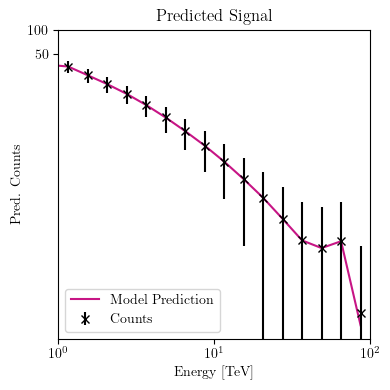

In [15]:
fig,ax = plt.subplots(1,1, sharey = True, figsize = (4,4))
ax =[ax]
plt.title("Predicted Signal")
fmts = ['o', 'x', '--', ':']
colors = ['orange', 'red', 'tab:blue', 'green']
plt.plot(energy,npreds_pre_fit[0],
         label = "Model Prediction", color = color_standard)

plt.errorbar(energy, sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data), 
             yerr = np.sqrt(sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data)),
            fmt = 'x', label = "Counts", color = 'black')

#plt.fill_between(energy, npreds_pre_fit[0], npreds_pre_fit[1],
#                 color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy reco.")

        
ax[0].loglog()
ax[0].legend(loc = 'lower left')
ax[0].set_xlabel("Energy [TeV]")
ax[0].set_ylabel("Pred. Counts")
#ax[0].set_ylim(2e1, 7e2)
plt.minorticks_off()
ax[0].set_yticks([50,100], ['50', '100'])
ax[0].set_xlim(1, 100)
plt.tight_layout()
fig.savefig(f"plots/2_Npred_single_simga_{sigma}.{figformat}")


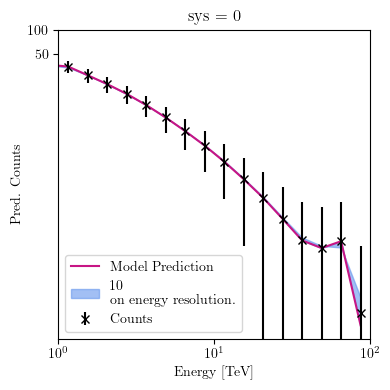

In [16]:

fig,ax = plt.subplots(1,len(datasets_conv), sharey = True, figsize =  (4,4))
if len(datasets_conv) == 1:
    ax = [ax]
for i in range(len((datasets_conv))):
    ax[i].plot(energy,npreds_pre_fit[i], label = "Model Prediction", color = color_standard)

for a in ax:
    try:
        a.fill_between(energy, npreds_pre_fit[0],sum_e(dataset_conv_extreme.npred_signal().data) ,
                 color = color_nui_e, alpha = 0.6, label = "10 % Systematic Error \n on energy resolution.")
    except:
        print("not enough")
    a.errorbar(energy, sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data), 
             yerr = np.sqrt(sum_e(datasets_conv[0].counts.data-datasets_conv[0].background.data)),
            fmt = 'x', label = "Counts", color = 'black')

        
    a.loglog()
    a.legend(loc = 'lower left')
    a.set_xlabel("Energy [TeV]")
    #a.set_ylim(2e1, 7e2)
    a.set_yticks([50,100], ['50', '100'])
    a.set_xlim(1,100)
ax[0].set_ylabel("Pred. Counts")
ax[0].set_title("sys = 0% (10%)"); 
#ax[1].set_title("sys = 0% (10%)"); ax[2].set_title("sys = 10% (10%)"); 

plt.minorticks_off()
plt.tight_layout()

fig.savefig(f"plots/2_Npred_simga_{sigma}.{figformat}")


In [17]:
datasets_conv[0].models.parameters['lambda_'].frozen = True
datasets_conv_N[0].models.parameters['lambda_'].frozen = True

corr
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 2.151e+05                  │              Nfcn = 238              │
│ EDM = 1.77e-07 (Goal: 2e-06)     │           time = 22.7 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────────────┬───────────┬───────────┬────────────┬────────────┬────────

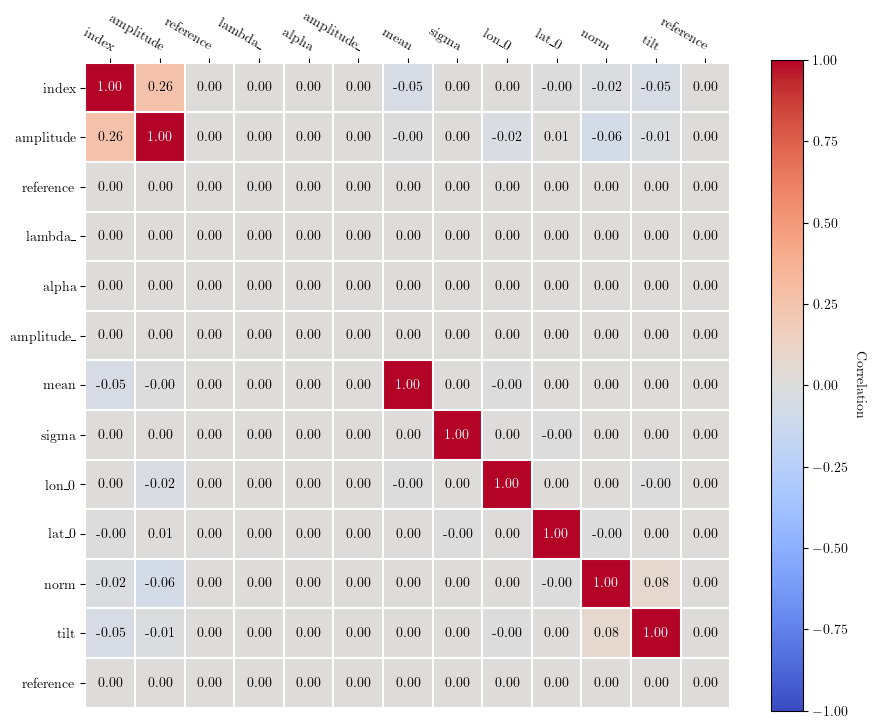

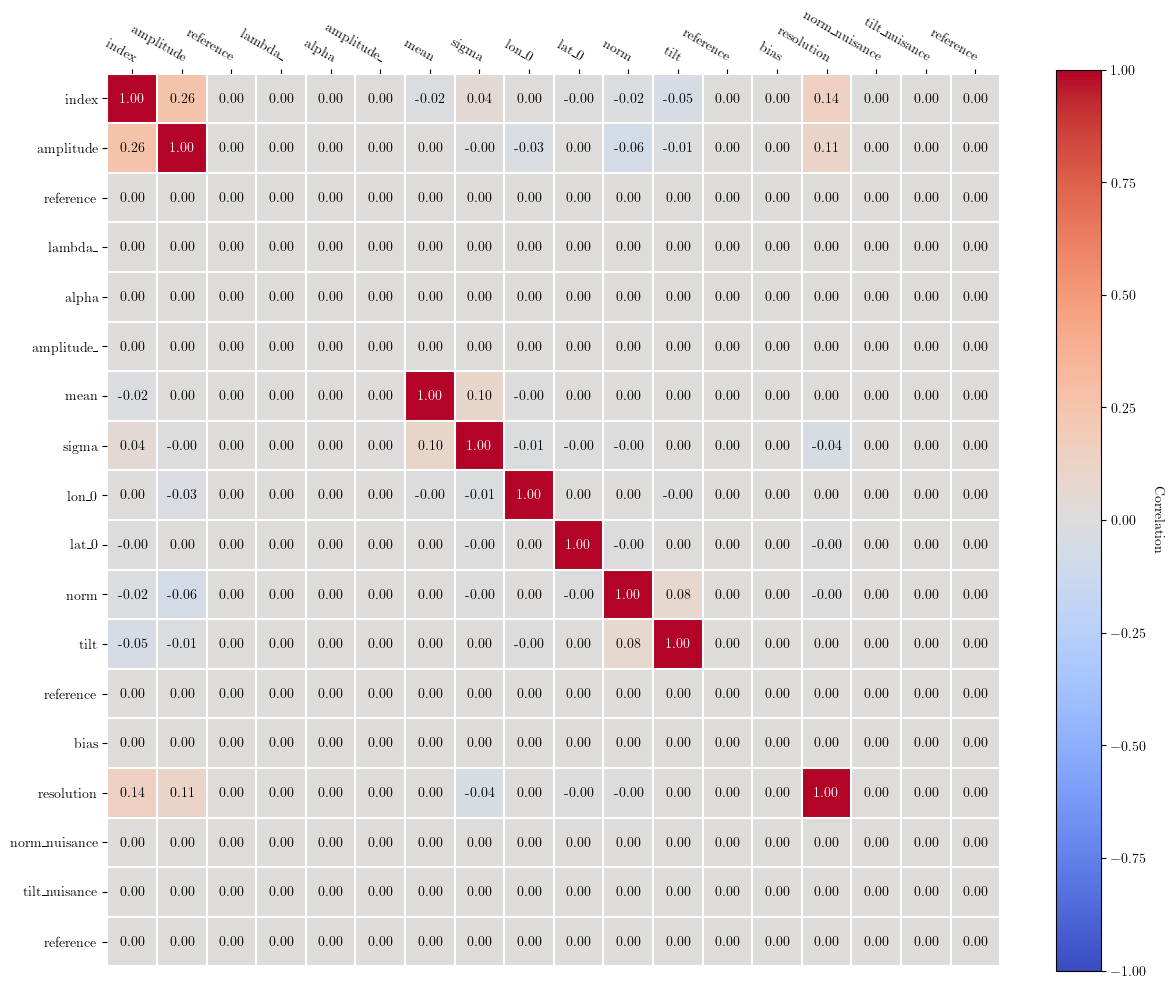

In [18]:
%%time
fitting = 1

if fitting:

    print("corr")
    for d in datasets_conv:
        fit_cor = Fit(store_trace=True)
        minuit_opts = {"tol": 0.001, "strategy": 2}
        fit_cor.optimize_opts = minuit_opts
        result_cor = fit_cor.run(d)
        d.models.covariance = fit_cor.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor.minuit)

    for d in datasets_conv_N:
        fit_cor_N = Fit(store_trace=True)
        fit_cor_N.optimize_opts = {"tol": 0.001, "strategy": 2}
        result_cor_N = fit_cor_N.run(d)
        d.models.covariance = fit_cor_N.covariance(d).matrix
        d.models.covariance.plot_correlation()
        print(fit_cor_N.minuit)
    
    print("saving")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_bias_0_{sigmass[i]}_simga_{sigma}.yml'
        d.models.write(path,overwrite=True)
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_bias_0_{sigmass[i]}_simga_{sigma}.yml'
        d.models.write(path,overwrite=True)
        
else:
    print("read")
    for i, d in enumerate(datasets_conv):
        path = f'data/2_model_bias_0_{sigmass[i]}_simga_{sigma}.yml'
        datasets_conv[i] = Dataset_load.load_dataset_N(d, path)        
    print("read nui")
    for i, d in enumerate(datasets_conv_N):
        path = f'data/2_model_nui_bias_0_{sigmass[i]}_simga_{sigma}.yml'
        datasets_conv_N[i] = Dataset_load.load_dataset_N(d, path)        
        
    



In [19]:
energy_bounds = [1,80 ] *u.TeV

['index', 'amplitude', 'mean', 'sigma', 'resolution']


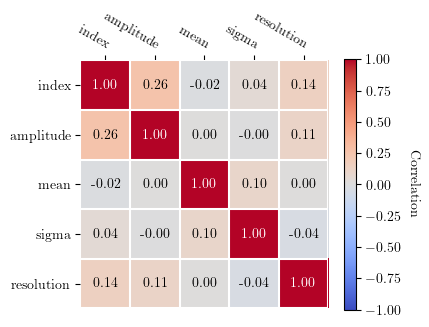

In [20]:
par_inter_names = ['index', 'amplitude', 'mean', 'sigma',  'resolution' ]
pars_inter = Parameters(
            [datasets_conv_N[0].models.parameters['index'],
             datasets_conv_N[0].models.parameters['amplitude'],
             datasets_conv_N[0].models.parameters['mean'],
             datasets_conv_N[0].models[0].parameters['sigma'],
             datasets_conv_N[0].irf_model.parameters['resolution'],
             
            ])

print(pars_inter.names)
datasets_conv_N[0].models.covariance.get_subcovariance(pars_inter).plot_correlation()
fig = plt.gcf()
fig.savefig(f'plots/2_cov_matrix_{sigma}_cut.{figformat}')


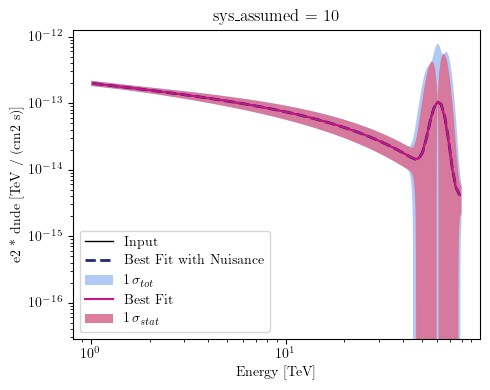

In [21]:
n_points = 1e4
width = 3*len(datasets_conv)
if len(datasets_conv):
    width = 5
fig,axs = plt.subplots(1,len(datasets_conv), sharey=True,figsize = (width,4))
if len(datasets_conv)==1:
    axs = [axs]
for i,ax in enumerate(axs):
    if i ==1:
         dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 2, linestyle="dashed")
    else:
        dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = 2, ax =ax, 
                                label = "Input", color = 'black', linewidth = 1, )
        
for i in range(len(datasets_conv_N)):
    
    dataset_neg_N = datasets_conv_N[i]
    dataset_neg_N.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           color=color_nui,
                                                             label="Best Fit with Nuisance",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2)        
    dataset_neg_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_nui_e,
                                                             label="1$\,\sigma_{tot}$",
                                                            alpha = 0.5,
                                                     n_points=n_points,)
    dataset_st_neg = datasets_conv[i]
    dataset_st_neg.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = axs[i],
                                    label = "Best Fit", color = color_standard)
    dataset_st_neg.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = axs[i],
                                                           facecolor=color_standard_e,
                                                              alpha = 0.9,
                                                              label= "1$\,\sigma_{stat}$",
                                                       n_points=n_points,
                                                             )
[a.legend(loc = 'lower left') for a in axs]
axs[0].set_title("sys_assumed = 10%"); 

#axs[1].set_title("sys = 0%"); axs[2].set_title("sys = +10%"); 
#axs[1].set_ylabel(''); axs[2].set_ylabel('')

plt.tight_layout()
fig = plt.gcf()
fig.savefig(f'plots/2_spectrum_comparison_{sigma}_cut.{figformat}')


In [22]:
from gammapy.maps import MapAxis, RegionNDMap
energy = MapAxis.from_energy_bounds(
     1*u.TeV,
            100*u.TeV,
            1e2,
        )
energy

MapAxis

	name       : energy    
	unit       : 'TeV'     
	nbins      : 100       
	node type  : edges     
	edges min  : 1.0e+00 TeV
	edges max  : 1.0e+02 TeV
	interp     : log       

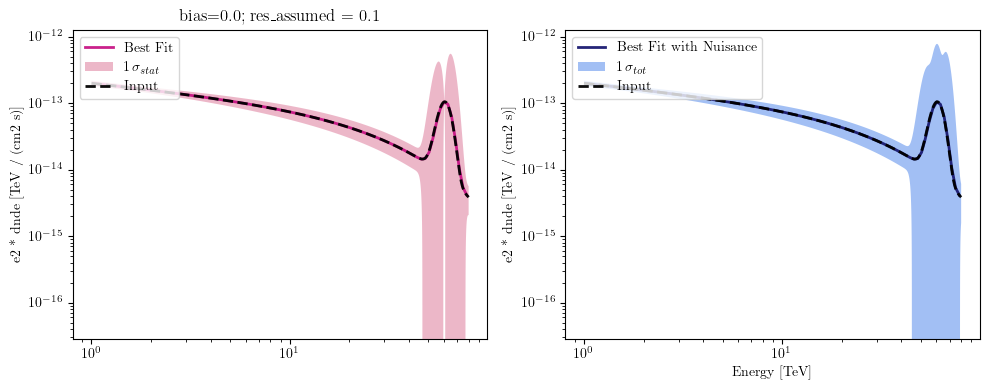

In [28]:


fig,axss = plt.subplots(len(datasets_conv_N),2, sharex = True, sharey=False, figsize = (10,4))
a = axss[1]
d = datasets_conv_N[0]
n_points = 1e4
d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                    color=color_nui,
                                                         label= f"Best Fit with Nuisance",
                                                        alpha = 0.95,
                                                       linestyle='-', linewidth= 2)       

d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = a,
                                                       facecolor=color_nui_e,
                                                         label="1$\,\sigma_{tot}$",
                                                        alpha = 0.6,
                                      n_points=n_points,)
d = datasets_conv[0]
a = axss[0]

d.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                       color=color_standard,
                                                         label= f"Best Fit",
                                                        alpha = 0.95,
                                                       linestyle='-', linewidth= 2)       

d.models[0].spectral_model.plot_error(energy_bounds,  energy_power = 2, ax = a,
                                                       facecolor=color_standard_e,
                                                         label="1$\,\sigma_{stat}$",
                                                        alpha = 0.5,
                                     n_points=n_points,)
axss[0].set_title(f"bias={b}; res_assumed = {res_assumed}")
for a in axss:
    dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = 2, ax = a,
                                                           color='black',
                                                             label="Input",
                                                            alpha = 0.95,
                                                           linestyle='dashed', linewidth= 2,
                                                n_points = n_points)  
    a.legend(loc = 'upper left')
    

ylim = axss[1].get_ylim()
axss[0].set_ylim(ylim[0], ylim[1])
axss[0].set_xlabel('')
plt.tight_layout()
fig.savefig(f'plots/2_Best_fit_Spectrum_{sigma}_cut.{figformat}')


In [24]:
def plot_par(par1, par2, label,ax = None, fmt ='x', markersize = 6):
    if ax is None:
        fig, ax = plt.subplots(1,1)
    ax.errorbar(x = par1.value, y = par2.value, xerr = par1.error, yerr = par2.error, fmt= fmt,
                markersize = markersize,
                label = label)
    ax.set_xlabel(f"{par1.name} [{par1.unit}] " )
    ax.set_ylabel(f"{par2.name} [{par2.unit}] " )
    ax.legend()
    
    return ax

def plot_source_par(model_name, pars):
    if len(pars)>2:
        fig, ax = plt.subplots(2,2, figsize = (6,6))
        ax = ax.flatten()
    else:
        fig, ax = plt.subplots(1,2, figsize = (6,3))
   
    for i, p in enumerate(pars):
    
        for j, m in enumerate (models_list):
            plot_par(m[0].parameters[p[0]],
                 m[model_name].parameters[p[1]],
                    label= labels[j],
                    ax = ax[i],
                        fmt = fmts[j],
                        markersize = markersize[j])

    plt.tight_layout()

labels = ['simulated', 'recovered pl', 'recovered ecpl']
fmts = ['o','x', '*']
markersize = [6,10,5]

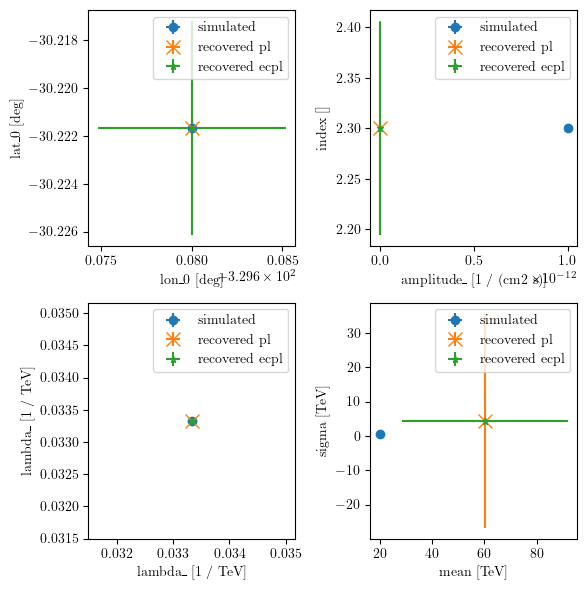

In [25]:
config = Dataset_load.load_config()
case = 'wecap'
models_list = [Dataset_load.set_model(path = config[case]["path_pksflare"], 
                                      model='plg'), datasets_conv_N[0].models ,
              datasets_conv[0].models ]
pars= [('lon_0', 'lat_0'),('amplitude_', 'index'),
                ('lambda_', 'lambda_'), ('mean', 'sigma')]

plot_source_par(0, pars)


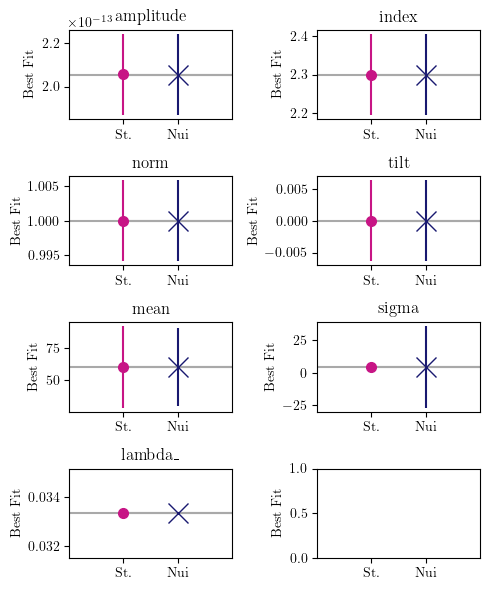

In [26]:
fig, axs = plt.subplots(4,2, figsize= (5, 6))
ax = axs.flatten()


parnames = ['amplitude', 'index', 'norm', 'tilt',
           'mean', 'sigma', 'lambda_']
ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'o', color = color_standard,markersize = 7,
                          label = f'Standard')
        
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar((ii+0.1), value, yerr = error, fmt = 'x', color = color_nui,markersize=14,
                          label ="Nuisance")
            ax[i].hlines(dataset_asimov.models.parameters[p].value, -0.1, 0.2,
                        color = 'darkgrey')
            
        ii +=1
labels_sys = [ 'St.', 'Nui']
for i, p in enumerate(parnames):
    value = dataset_asimov.models.parameters[p].value
    error = dataset_asimov.models.parameters[p].error    
    ax[i].hlines( value, 0, len(labels_sys)-1, label = "input", color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.set_ylabel('Best Fit'); 
    ax.set_xticks([0, 0.1],labels_sys)
    ax.set_xlim(-0.1, 0.2)
plt.tight_layout()
fig.savefig(f'plots/2_Best_fit_parameters_{sigma}_cut.{figformat}')
    

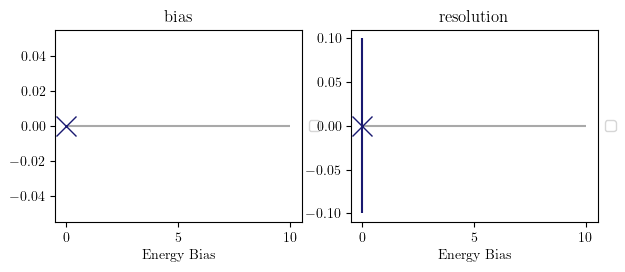

In [27]:
fig,ax  = plt.subplots(1,2,figsize= (7, 2.5))
ax = ax.flatten()
parnames = ['bias', 'resolution',]
labels_sys = []

ii =0;
for b in biass:
    for s in sigmass:
        d = datasets_conv_N[ii]
        for i, p in enumerate(parnames):
            value = d.models.parameters[p].value
            error = d.models.parameters[p].error    
            ax[i].errorbar(ii, value, yerr = error, fmt = 'x', color = color_nui,markersize=14,)
            ax[i].set_title(p)
            
        labels_sys.append(f'B={b};\n R={s};')
            
            
        ii +=1
        
labels_sys = [ '0%', '5%', '10%']
for i, p in enumerate(parnames):
    value = 0
    #ax[i].errorbar(4, value, yerr = error, fmt = 'x')
    ax[i].hlines( value, 0, len(labels_sys)-1,  color= 'darkgrey')
    ax[i].set_title(p)
    
    
for ax in ax:
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), ncol = 1, 
            loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_xlabel('Energy Bias'); 
    ax.set_xticks(np.arange(len(labels_sys)),labels_sys)
fig.savefig(f'plots/2_Best_fit_nui_parameters_{sigma}.{figformat}')
    